In [1]:
import numpy as np
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
import torch
from torch.utils import data
from dataset import PlacesDataset
from data_dicts import Dicts
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam,SGD
from sklearn.metrics import jaccard_similarity_score as jss
from skimage.segmentation import find_boundaries as fb
from unet_model import Unet

In [2]:
dic=Dicts()
train_files,val_files=dic.get_dicts()

In [3]:
def showimage(image,tor):
    if tor==1:
        image=image.numpy().transpose(1,2,0)
        image=image[:,:,::-1]
    plt.imshow(image)
    plt.show()

In [4]:
#train_dataset_1=PlacesDataset(train_files,augment=10,normalize_augment=True, transforms=True)
train_dataset=PlacesDataset(train_files,augment=10,normalize_augment=False, transforms=True)
#train_dataset=data.ConcatDataset((train_dataset_1,train_dataset_2))
val_dataset=PlacesDataset(val_files,augment=10,transforms=True)
indices_test=range(200,500,1)
indices_val=range(0,200)
test_dataset=data.Subset(val_dataset, indices_test)
val_dataset=data.Subset(val_dataset, indices_val)

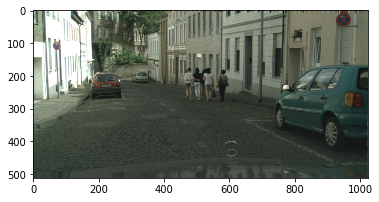

In [5]:
img,label=train_dataset[1500]
showimage(img,1)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=2)
validation_loader = torch.utils.data.DataLoader(val_dataset,batch_size=1)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1)

In [13]:
unet=Unet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
unet=unet.to(device)
optimizer=SGD(unet.parameters(),lr=8*10**(-3))

cuda


In [14]:
def loss_function(input_image,target_image,size_average=True,weight=None):
    n,c,h,w=input_image.size()
    nt,ht,wt=target_image.size()
    
    if (h!=ht and w!=wt):
        input_image=F.interpolate(input_image, size=(ht, wt), mode="bilinear", align_corners=True)
        
    input_image=input_image.transpose(1,2).transpose(2,3).contiguous()
    for i in range(target_image.size(0)):
        mask=fb(target_image[i].cpu().numpy(),mode='outer').astype(np.uint8)
        mask+=1
        mask=torch.from_numpy(mask).type(torch.cuda.FloatTensor)
        if i==0:
            loss=(F.cross_entropy(input_image[i].view(-1,c),target_image[i].view(-1),reduction='none')*mask.view(-1)).mean()
        else:
            loss+=(F.cross_entropy(input_image[i].view(-1,c),target_image[i].view(-1),reduction='none')*mask.view(-1)).mean()
        
    return loss

In [15]:
def train(input_image,target_image,optimizer):
    optimizer.zero_grad()
    output_image=unet(input_image)
    loss=loss_function(output_image,target_image)
    loss.backward()
    optimizer.step()
    return loss.item()

In [16]:
def val_loss_function(output_model,target):
    n,c,h,w=output_model.size()
    nt,ht,wt=target.size()
    
    if (h!=ht and w!=wt):
        output_model=F.interpolate(output_model, size=(ht, wt), mode="bilinear", align_corners=True)
        
    output_model=F.softmax(output_model.squeeze(0),dim=0).transpose(0,1).transpose(1,2)
    predicted=np.zeros((ht,wt))
    target=target.squeeze(0).cpu().numpy().reshape(-1)
    output_model=output_model.squeeze(0).cpu().numpy()
    predicted=np.argmax(output_model,axis=2)
    predicted=predicted.reshape(-1)
    #predicted[predicted==19]=250
    score=jss(target,predicted)
    return score

In [17]:
def validation(input_image,target_image):
    with torch.no_grad():
        output_image=unet(input_image)
        loss=val_loss_function(output_image,target_image)
        return loss

In [18]:
checkpoint = torch.load('model.pth')
unet.load_state_dict(checkpoint['model_state_dict'])
batch = checkpoint['epoch']
tl = checkpoint['tl']
vl = checkpoint['vl']
unet.train()

Unet(
  (conv1a): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv1b): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2b): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Sequential(
    (0): Conv2d(128,

In [ ]:
#tl=[]
#vl=[]
benchmark=np.amax(vl)
for batch in range(48,49):
    running_loss=0
    for i,inputs in enumerate(train_loader):
        input_image=Variable(inputs[0]).to(device)
        target_image=(inputs[1]).to(device)
        loss=train(input_image,target_image,optimizer)
        running_loss+=loss
        tl.append(loss)
        if (i+1)%93==0:
            loss_val=0
            for j,inputs in enumerate(validation_loader):
                input_image=(inputs[0]).to(device)
                target_image=(inputs[1]).to(device)
                loss_val+=validation(input_image,target_image)
            loss_val=loss_val/(j+1)
            vl.append(loss_val)
            print ('Step: {} | Batch: {} | Training loss: {} | Validation IoU: {}'.format(int((i+1)/93), batch+1, running_loss, loss_val))
            running_loss=0
            if(loss_val>benchmark):
                print('%--Saving the model--%')
                torch.save({
                    'step':int((i+1)/93),
                    'epoch': batch+1,
                    'model_state_dict': unet.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'tl': tl,
                    'vl': vl
                    }, 'model.pth')
                benchmark=loss_val
            
            

Step: 1 | Batch: 49 | Training loss: 92.4498148560524 | Validation IoU: 0.8176774501800537
%--Saving the model--%
Step: 2 | Batch: 49 | Training loss: 90.26681274175644 | Validation IoU: 0.8184966278076172
%--Saving the model--%
Step: 3 | Batch: 49 | Training loss: 90.21970069408417 | Validation IoU: 0.8183046150207519
